In [1]:
import numpy as np

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regular as regular

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk

from pprint import pprint

from axon import loads, dumps
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [2]:
X, Y = load_boston(True)
print(X.shape)
scaler = MinMaxScaler()
Xt = scaler.fit_transform(X)

(506, 13)


In [3]:
def sigma_neuron_layer2(n_input, n_output):
    layer = model.GeneralModelLayer(n_input)
    outfunc = func.Sigmoidal()
    for i in range(n_output):
        mod = model.SigmaNeuronModel(outfunc, n_input)
        layer.models.append(mod)
    layer.n_input = n_input
    layer.n_output = n_output
    layer.n_param = sum(mod.n_param for mod in layer.models)
    return layer

In [4]:
def sigma_neuron_layer(n_input, n):
    layer = model.SigmaNeuronModelLayer(func.Sigmoidal(), n_input, n)
    return layer

In [5]:
def create_nn(n_hidden):
    n_input = X.shape[1]
    layer1 = sigma_neuron_layer2(n_input, n_hidden)
    #layer1 = sigma_neuron_layer(n_input, n_hidden)

    body = model.FFNetworkModel()
    body.add(layer1)

    head = model.LinearModel(n_hidden)
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [6]:
n_hidden = 20

In [7]:
ffnn1 = create_nn(n_hidden)
ffnn1.param[:] = np.random.random(size=ffnn1.n_param)
ffnn2 = create_nn(n_hidden)
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)
ffnn3 = create_nn(n_hidden)
ffnn3.param[:] = np.random.random(size=ffnn3.n_param)
ffnn4 = create_nn(n_hidden)
ffnn4.param[:] = np.random.random(size=ffnn4.n_param)

In [8]:
# lr = ffnn1.body.layers[0]
# lr.param[0]=1
# lr.matrix[1,1]=2
# print(np.array(lr.param))

Completed? False


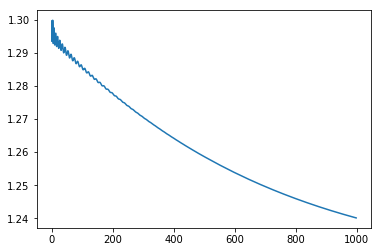

In [97]:
loss_func = loss.ErrorLoss(func.Square())
er = erisk(Xt, Y, ffnn1, loss_func)
_fg = erm_fg(er, h=0.005, tol=1.0e-8, n_iter=1000)
print("Completed?", _fg.completed)

plt.plot(_fg.lvals)
plt.show()

Completed? True


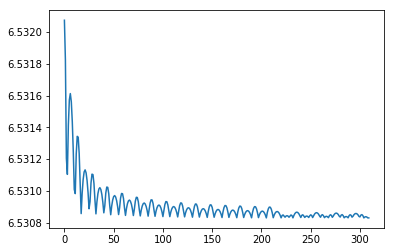

In [98]:
loss_func2 = loss.ErrorLoss(func.Absolute())
er2 = erisk(Xt, Y, ffnn2, loss_func2)
_fg2 = erm_fg(er2, h=0.005, tol=1.0e-8, n_iter=1000)
print("Completed?", _fg2.completed)

plt.plot(_fg2.lvals)
plt.show()

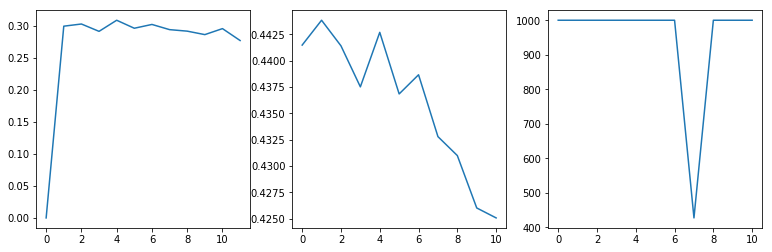

In [99]:
loss_func3 = loss.ErrorLoss(func.Square())
er3 = erisk(Xt, Y, ffnn3, loss_func3)
_fg3 = fg(er3, h=0.005, tol=1.0e-8, n_iter=1000)
avg3 = averager_it(func.QuantileFunc(0.90, func.Sqrt(1.0)))
wg3 = weights.WMWeights(avg3, er3)
irgd3 = erm_irgd(_fg3, wg3, n_iter=11)

plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.plot(irgd3.lvals)
plt.subplot(1,3,2)
plt.plot(irgd3.qvals)
plt.subplot(1,3,3)
plt.plot(irgd3.n_iters)
plt.show()

In [100]:
# loss_func4 = loss.ErrorLoss(func.Square())
# er4 = erisk(Xt, Y, ffnn4, loss_func4)
# fg4 = fg(er4, h=0.01, tol=1.0e-6)
# avg4 = averager_it(func.QuantileFunc(0.51, func.Sqrt(0.001)))
# #avg4 = averager_it(func.Sqrt(0.001))
# wg4 = weights.MWeights(avg4, er4)
# irgd4 = erm_irgd(fg4, wg4, n_iter=21, verbose=0)

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(irgd4.lvals)
# plt.subplot(1,2,2)
# plt.plot(irgd4.n_iters)
# plt.show()

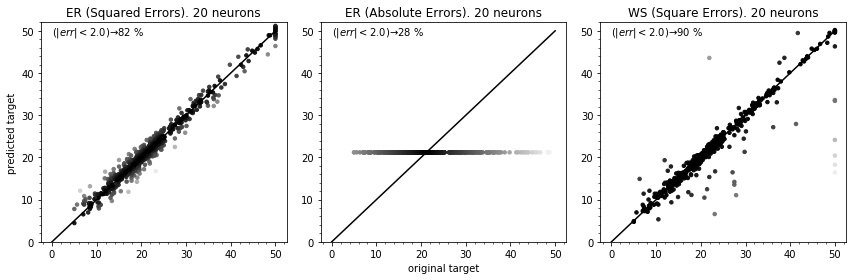

In [101]:
b = 2.0
Yp1 = np.array([ffnn1(x) for x in Xt])
Yp2 = np.array([ffnn2(x) for x in Xt])
Yp3 = np.array([ffnn3(x) for x in Xt])
#Yp4 = np.array([ffnn4(x) for x in Xt])
data = [
    { 'Y':Yp1, 'title':'ER (Squared Errors). %s neurons' % n_hidden },
    { 'Y':Yp2, 'title':'ER (Absolute Errors). %s neurons' % n_hidden },
    { 'Y':Yp3, 'title':'WS (Square Errors). %s neurons' % n_hidden },
    #{ 'Y':Yp4, 'title':'M (Square Errors). %s neurons' % n_hidden },
]
plt.figure(figsize=(len(data)*4.0, 4.0))
for i, d in enumerate(data):
    Y1 = d['Y']
    title = d['title'] 
    plt.subplot(1, 3, i+1)
    plt.title(title)
    V = np.abs(Y-Y1)
    I = np.argsort(V)
    I = I[::-1]
    plt.scatter(Y[I], Y1[I], c=V[I], s=12, cmap=plt.cm.gray)
    c = sum(V < b) / len(V) * 100
    plt.text(0, 49, r'$(|err|<%.1f)\to%s$ %%' % (b, int(c)))
    plt.plot([0,50],[0,50], c='k')
    if i == 1:
        plt.xlabel("original target")
    if i == 0:
        plt.ylabel("predicted target")
    plt.ylim(0, 52)
    plt.minorticks_on()
plt.savefig(r"fig/nn_boston_2_%s.pdf" % n_hidden)
plt.tight_layout()
plt.show()

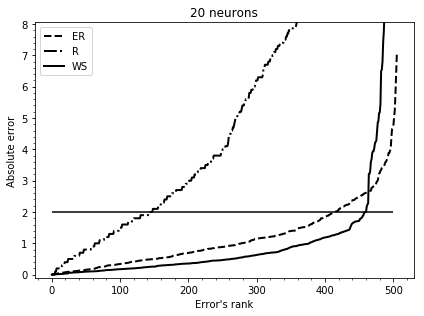

In [102]:
plt.figure(figsize=(6,4.5))
plt.title('%s neurons' % n_hidden)
Z = np.abs(Yp1-Y)
Z2 = np.abs(Yp2-Y)
Z3 = np.abs(Yp3-Y)
#Z4 = np.abs(Yp4-Y)
plt.plot(sorted(Z), label='ER', color='k', linestyle='--', linewidth=2.0)
plt.plot(sorted(Z2), label='R', color='k', linestyle='-.', linewidth=2.0)
plt.plot(sorted(Z3), label='WS', color='k', linestyle='-', linewidth=2.0)
#plt.plot(sorted(Z4), label='M', color='k', linestyle=':', linewidth=2.0)
plt.hlines(2.0, 0, 500)
plt.legend()
plt.ylim(-0.1, np.max(Z)+1)
plt.savefig(r"fig/nn_boston_1_%s.pdf" % n_hidden)
plt.minorticks_on()
plt.xlabel("Error's rank")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.show()

In [15]:
# plt.figure(figsize=(8,6))
# plt.plot(sorted(np.abs(Yp-Y)), label='BP', color='k', linestyle='--', linewidth=2.5)
# plt.plot(sorted(np.abs(Yp3-Y)), label='M-BP', color='k', linestyle='-', linewidth=2.5)
# #plt.plot(np.sort(np.abs(Yp3-Y)), label='M')
# plt.legend()
# #plt.ylim(-0.3, 6.)
# plt.savefig("fig/nn_boston_4.pdf")
# plt.show()